In [185]:
#vårt projekt

from typing import Tuple

from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.utils.data import dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR
import random
import numpy as np
import math

import matplotlib.pyplot as plt
from tqdm import tqdm

In [186]:
print(torch.__version__)

2.1.1


In [187]:
# pip install sentencepiece
# pip install tqdm
#conda install pytorch torchvision torchaudio -c pytorch
#python -m pip uninstall pytorch

In [188]:
import sentencepiece as spm

In [189]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

In [190]:
if torch.cuda.is_available():
    device = 'cuda'

else:
    device = 'cpu'
DEVICE = torch.device(device)
DEVICE


device(type='cpu')

In [191]:
#Alice paths
data_path = '/Users/alicetottie/Downloads/projekt_data/train_paracrawl.en'
data_path_2 = '/Users/alicetottie/Downloads/projekt_data/train_paracrawl.sv'

#Maja paths
# data_path = '/Users/majarygard/Documents/LTH/Projekt i Data/train_paracrawl.en'
# data_path_2 = '/Users/majarygard/Documents/LTH/Projekt i Data/train_paracrawl.sv'

#Pernilla paths
#data_path = 'C:\\Users\\nilla\\Plugg\\project-data\\train_paracrawl.en\\train_paracrawl.en'
#data_path_2 = 'C:\\Users\\nilla\\Plugg\\project-data\\train_paracrawl.sv\\train_paracrawl.sv'


In [192]:
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

with open(data_path_2, "r", encoding="utf-8") as f:
    lines2 = f.read().split("\n")    

In [193]:
len(lines)



4960283

In [194]:
len(lines2)

4960283

In [195]:
num_samples = 1000
input_texts = []
target_texts = []

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text= line.split("\t")
    input_texts.append(input_text)

with open("input_texts.txt", "w", encoding='utf-8') as f:
    for input_text in input_texts:
        f.write('\t'.join(input_text) + '\n')
    
for line in lines2[: min(num_samples, len(lines2) - 1)]:
    target_text= line.split("\t")
    target_texts.append(target_text)  

with open("input_texts.txt", "a", encoding='utf-8') as f:
    for target_text in target_texts:
        f.write('\t'.join(target_text) + '\n') 

In [196]:
input_texts[500]



['" This is my third course and I bought this concept a long time ago.']

In [197]:
target_texts[500]

['" Det här är min tredje kurs och jag har köpt det hela för länge sedan.']

In [198]:
TRAIN_PERCENTAGE = 0.8
train_val = int(TRAIN_PERCENTAGE * num_samples)
train_val

800

In [199]:
text_pairs = list(zip(input_texts, target_texts))
random.shuffle(text_pairs)
input_texts, target_texts = zip(*text_pairs)
input_texts, target_texts = list(input_texts), list(target_texts)


In [200]:
train_input_texts = input_texts[:train_val]
train_target_texts = target_texts[:train_val]

val_input_texts = input_texts[train_val:]
val_target_texts = target_texts[train_val:]

In [201]:
spm.SentencePieceTrainer.train('--input=input_texts.txt --model_prefix=m --vocab_size=4000 --model_type=bpe --pad_id=3')

# makes segmenter instance and loads the model file (m.model)
sp = spm.SentencePieceProcessor()
sp.load('m.model')

sp.SetEncodeExtraOptions("bos:eos")
sp.SetDecodeExtraOptions("bos:eos")

# encode: text => id
print(sp.encode_as_pieces('This is a test'))
print(sp.encode_as_ids('This is a test'))

# decode: id => text
print(sp.decode_pieces(['▁This', '▁is', '▁a', '▁t', 'est']))
print(sp.decode_ids([1, 665, 64, 5, 4, 134, 2]))

['<s>', '▁This', '▁is', '▁a', '▁test', '</s>']
[1, 1221, 120, 6, 2384, 2]
This is a test
honomill terte


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=input_texts.txt --model_prefix=m --vocab_size=4000 --model_type=bpe --pad_id=3
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: input_texts.txt
  input_format: 
  model_prefix: m
  model_type: BPE
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id:

In [202]:
def text2codes(texts, sp):
    codes = []
    for text in texts:
        text_l = text[0]
        code = sp.encode_as_ids(text_l)
        n_code = torch.tensor(code)
        codes.append(n_code)

    return codes



=1387 piece=▁jord
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=13 min_freq=7
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=13 size=1420 all=18619 active=1013 piece=Lukasev
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=12 size=1440 all=18665 active=1059 piece=:17
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=12 size=1460 all=18781 active=1175 piece=▁50
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=12 size=1480 all=18844 active=1238 piece=▁död
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=12 size=1500 all=18901 active=1295 piece=▁(142
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=12 min_freq=7
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=12 size=1520 all=18907 active=1007 piece=▁många
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=11 size=1540 all=18909 active=1009 piece=IT
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=11 size=1560 all=19013 active=1113 piece=ret
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=11 size=1580 

In [203]:
train_input_texts[:3], train_target_texts[:3]

([["!!TheM!Z!! hasn't added any friends yet!"],
  ['" Memory / Summerday" gouache/wood/butterfly 48x75 / 48x92cm 2006'],
  ['" child safety in Egypt "" harmfulness of the sun in Egypt on baby skin "" what medications the child in Egypt "" where on holiday with his family to Egypt "" pediatrician "" in which the child free hotels "']],
 [['!!TheM!Z!! har inte lagt till några vänner ännu!'],
  ['"Hågkomst / Sommardag" gouache/trä 48x75 /48x92cm2006'],
  ['" barnsäkerhet i Egypten "" skadlighet solen i Egypten på baby hud "" vilka mediciner barnet i Egypten "" där på semester med sin familj till Egypten "" barnläkare "" där barnet hotellsökningen "']])

In [204]:
text2codes(train_input_texts[:3], sp)[:3]

[tensor([   1,  311, 3644, 3937, 3980,  592,  611, 3958, 3896, 3256,  403, 1955,
          526, 3937,    2]),
 tensor([   1,    8,   69,  173,  651,  439,   58,  174,  521, 2510, 3907,   52,
           48,  447,   13, 3964, 2599, 3964, 3915, 3908, 1279, 2964,  390, 3960,
         3954, 2461,  439,  390, 3960, 3954, 1787,  987,  321, 3953,    2]),
 tensor([   1,    8,  353,  398, 3828,   19, 3916,   37,  158,   75,  175, 3905,
          520,  808,   44,   29, 2646,   37,  158,  153,   21, 2948, 3220,   75,
          482, 1938,  663,   29,  353,  398,   37,  158,   75, 1312,  153, 2875,
          202,  410, 3317,   61,  158,   75,   31,   35, 2968, 1347,  578,   75,
           37,  382,   29,  353,  398,   14,  770, 1948,    8,    2])]

In [205]:
def codes2text(codes):
    texts = []
    for code in codes:
        code_l = list(code)
        for p in code_l:
            texts.append(sp.id_to_piece(p.item()))
    return texts

In [206]:
codes2text(text2codes(train_input_texts[:3], sp)[:3])

['<s>',
 '▁!!',
 'TheM',
 '!',
 'Z',
 '!!',
 '▁hasn',
 "'",
 't',
 '▁added',
 '▁any',
 '▁friends',
 '▁yet',
 '!',
 '</s>',
 '<s>',
 '▁"',
 '▁M',
 'em',
 'ory',
 '▁/',
 '▁S',
 'um',
 'mer',
 'day',
 '"',
 '▁g',
 'ou',
 'ac',
 'he',
 '/',
 'wood',
 '/',
 'b',
 'u',
 'tter',
 'fly',
 '▁4',
 '8',
 'x',
 '75',
 '▁/',
 '▁4',
 '8',
 'x',
 '92',
 'cm',
 '▁200',
 '6',
 '</s>',
 '<s>',
 '▁"',
 '▁ch',
 'ild',
 '▁saf',
 'et',
 'y',
 '▁in',
 '▁Egypt',
 '▁""',
 '▁har',
 'm',
 'ful',
 'ness',
 '▁of',
 '▁the',
 '▁sun',
 '▁in',
 '▁Egypt',
 '▁on',
 '▁b',
 'aby',
 '▁skin',
 '▁""',
 '▁what',
 '▁medic',
 'ations',
 '▁the',
 '▁ch',
 'ild',
 '▁in',
 '▁Egypt',
 '▁""',
 '▁where',
 '▁on',
 '▁holiday',
 '▁with',
 '▁his',
 '▁family',
 '▁to',
 '▁Egypt',
 '▁""',
 '▁p',
 'ed',
 'iat',
 'ric',
 'ian',
 '▁""',
 '▁in',
 '▁which',
 '▁the',
 '▁ch',
 'ild',
 '▁f',
 'ree',
 '▁hotels',
 '▁"',
 '</s>']

In [207]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)
                        * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)
        self.emb_size = emb_size

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding * math.sqrt(self.emb_size)
                            + self.pos_embedding[:token_embedding.size(0), :])

In [208]:
pe = PositionalEncoding(10, 0.1)

In [209]:
torch.zeros(1, 5, 10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [210]:
pe(torch.zeros(1, 5, 10))

tensor([[[0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 0.0000],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 0.0000, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111]]])

In [ ]:
# # Seq2Seq Network
# import torch
# import torch.nn as nn
# from torch import Tensor
# from torch.nn import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer

# class Seq2SeqTransformer(nn.Module):
#     def __init__(self,
#                  num_encoder_layers: int,
#                  num_decoder_layers: int,
#                  emb_size: int,
#                  nhead: int,
#                  vocab_size: int,
#                  dim_feedforward: int = 512,
#                  dropout: float = 0.1):
#         super().__init__()
#         encoder_layers = TransformerEncoderLayer(emb_size, nhead, dim_feedforward, dropout)
#         decoder_layers = TransformerDecoderLayer(emb_size, nhead, dim_feedforward, dropout)
#         self.transformer_encoder = TransformerEncoder(encoder_layers, num_encoder_layers)
#         self.transformer_decoder = TransformerDecoder(decoder_layers, num_decoder_layers)

#         self.emb_size = emb_size
#         self.embedding = nn.Embedding(
#             vocab_size, emb_size, padding_idx=3)
#         self.positional_encoding = PositionalEncoding(
#             emb_size, dropout=dropout)
#         self.generator = nn.Linear(emb_size, vocab_size, bias=False)
#         self.generator.weight = self.embedding.weight

#     def forward(self,
#                 src: Tensor,
#                 trg: Tensor,
#                 src_mask: Tensor,
#                 tgt_mask: Tensor,
#                 src_padding_mask: Tensor,
#                 tgt_padding_mask: Tensor,
#                 memory_key_padding_mask: Tensor):
#         src_emb = self.positional_encoding(self.embedding(src))
#         tgt_emb = self.positional_encoding(self.embedding(trg))
        
#         memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
#         outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
#                                         tgt_padding_mask, memory_key_padding_mask)
#         return self.generator(outs)

#     def encode(self, src: Tensor, src_mask: Tensor):
#         return self.transformer_encoder(self.positional_encoding(
#             self.embedding(src)), src_mask)

#     def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
#         return self.transformer_decoder(self.positional_encoding(
#             self.embedding(tgt)), memory,
#             tgt_mask)

In [211]:
# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super().__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)

        self.emb_size = emb_size
        # Same source and target embs Sect. 3.4
        self.embedding = nn.Embedding(
            vocab_size, emb_size, padding_idx=3)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        # Bias to be compatible with embeddings
        self.generator = nn.Linear(emb_size, vocab_size, bias=False)
        self.generator.weight = self.embedding.weight  # Shared weights Sect. 3.4

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.embedding(src))
        tgt_emb = self.positional_encoding(self.embedding(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
            self.embedding(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
            self.embedding(tgt)), memory,
            tgt_mask)


In [212]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float(
        '-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [213]:
generate_square_subsequent_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [214]:
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),
                           device=DEVICE).type(torch.bool)

    src_padding_mask = (src == 3).transpose(0, 1)
    tgt_padding_mask = (tgt == 3).transpose(0, 1).type(torch.float32)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


In [215]:
src = pad_sequence(text2codes(
    train_input_texts[:3], sp), padding_value=3)
tgt = pad_sequence(text2codes(
    train_target_texts[:3], sp), padding_value=3)

In [216]:
train_input_texts[:3], train_target_texts[:3]

([["!!TheM!Z!! hasn't added any friends yet!"],
  ['" Memory / Summerday" gouache/wood/butterfly 48x75 / 48x92cm 2006'],
  ['" child safety in Egypt "" harmfulness of the sun in Egypt on baby skin "" what medications the child in Egypt "" where on holiday with his family to Egypt "" pediatrician "" in which the child free hotels "']],
 [['!!TheM!Z!! har inte lagt till några vänner ännu!'],
  ['"Hågkomst / Sommardag" gouache/trä 48x75 /48x92cm2006'],
  ['" barnsäkerhet i Egypten "" skadlighet solen i Egypten på baby hud "" vilka mediciner barnet i Egypten "" där på semester med sin familj till Egypten "" barnläkare "" där barnet hotellsökningen "']])

In [217]:
create_mask(src, tgt)

(tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]),
 tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., 0., -inf,  ..., -inf, -inf, -inf],
         [0., 0., 0.,  ..., -inf, -inf, -inf],
         ...,
         [0., 0., 0.,  ..., 0., -inf, -inf],
         [0., 0., 0.,  ..., 0., 0., -inf],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  

In [229]:
VOCAB_SIZE = 4000 #max(token2idx.values()) + 1  # or len(token2idx)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6


In [231]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [232]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=3)

optimizer = torch.optim.Adam(
            transformer.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
        )
lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=transformer.emb_size, factor=1.0, warmup=4000
        ),
    )

In [233]:
from torch.utils.data import Dataset, DataLoader

In [234]:
class PairDataset(Dataset):
    def __init__(self, input_texts, target_texts, token2idx):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.token2idx = token2idx

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        src_batch = text2codes([input_texts[idx]], self.token2idx)
        tgt_batch = text2codes([target_texts[idx]], self.token2idx)

        return src_batch[0], tgt_batch[0]

    def collate(self, batch):
        src_batch, tgt_batch = list(zip(*batch))
        src_batch = pad_sequence(src_batch, padding_value=3)
        tgt_batch = pad_sequence(tgt_batch, padding_value=3)

        return src_batch, tgt_batch

In [235]:
train_dataset = PairDataset(train_input_texts, train_target_texts, sp)
train_dataloader = DataLoader(train_dataset, batch_size=32,
                              shuffle=True, collate_fn=train_dataset.collate)

In [236]:
val_dataset = PairDataset(val_input_texts, val_target_texts, sp)
val_dataloader = DataLoader(
    val_dataset, batch_size=32, collate_fn=val_dataset.collate)

In [237]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

In [238]:
def train_epoch(model, optimizer, dataloader, scheduler, accum_iter=1, train_state=TrainState()):
    model.train()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0
    for src_batch, tgt_batch in tqdm(dataloader):
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src,
                       tgt_input,
                       src_mask,
                       tgt_mask,
                       src_padding_mask,
                       tgt_padding_mask,
                       src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        losses += loss.item()

        with torch.no_grad():
            sent_cnt += tgt_out.size()[-1]

            total += torch.numel(tgt_input)
            _, char_pred = torch.max(logits, -1)
            correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total


In [239]:
def evaluate(model, dataloader):
    model.eval()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0

    for src_batch, tgt_batch in dataloader:
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                       src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        sent_cnt += tgt_out.size()[-1]

        total += torch.numel(tgt_input)
        _, char_pred = torch.max(logits, -1)
        correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total


In [240]:
from timeit import default_timer as timer
NUM_EPOCHS = 15
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss, train_acc = train_epoch(
        transformer, optimizer, train_dataloader, lr_scheduler)
    train_losses += [train_loss]
    train_accs += [train_acc]
    end_time = timer()
    val_loss, val_acc = evaluate(transformer, val_dataloader)
    val_losses += [val_loss]
    val_accs += [val_acc]
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train acc.: {train_acc:.3f}, Val acc.: {val_acc:.3f}, Epoch time = {(end_time - start_time):.3f}s"))


100%|██████████| 25/25 [00:42<00:00,  1.72s/it]


Epoch: 1, Train loss: 0.262, Val loss: 0.292, Train acc.: 0.008, Val acc.: 0.001, Epoch time = 42.894s


100%|██████████| 25/25 [00:41<00:00,  1.65s/it]


Epoch: 2, Train loss: 0.259, Val loss: 0.287, Train acc.: 0.002, Val acc.: 0.001, Epoch time = 41.186s


100%|██████████| 25/25 [00:39<00:00,  1.60s/it]


Epoch: 3, Train loss: 0.255, Val loss: 0.280, Train acc.: 0.003, Val acc.: 0.009, Epoch time = 39.952s


100%|██████████| 25/25 [00:40<00:00,  1.64s/it]


Epoch: 4, Train loss: 0.250, Val loss: 0.275, Train acc.: 0.009, Val acc.: 0.011, Epoch time = 40.963s


100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


Epoch: 5, Train loss: 0.245, Val loss: 0.270, Train acc.: 0.011, Val acc.: 0.012, Epoch time = 38.248s


100%|██████████| 25/25 [00:40<00:00,  1.64s/it]


Epoch: 6, Train loss: 0.241, Val loss: 0.266, Train acc.: 0.011, Val acc.: 0.013, Epoch time = 40.929s


 20%|██        | 5/25 [00:08<00:32,  1.62s/it]
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

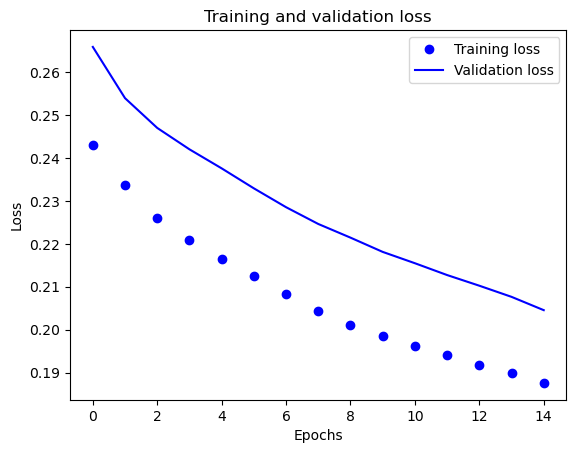

In [89]:
epochs = range(NUM_EPOCHS)

plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

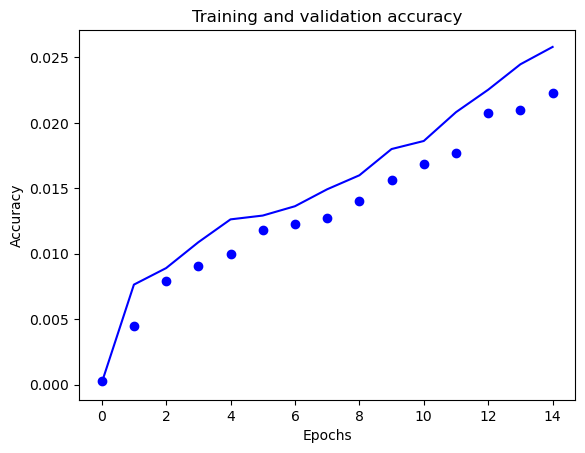

In [90]:
plt.plot(epochs, train_accs, 'bo', label='Training acc')
plt.plot(epochs, val_accs, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [91]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    # print(ys)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        # print(ys) # Remove the comment to understand the loop
        if next_word == 2:
            break
    return ys


In [92]:
text2codes(['Go!'], sp)[0].view(-1, 1)

tensor([[  1],
        [138],
        [  2]])

In [93]:
# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text2codes([src_sentence], sp)[0].view(-1, 1)
    print("SRC: ", src)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, src, src_mask, max_len=num_tokens + 20, start_symbol=1).flatten()
    print("Targ: ", tgt_tokens)
    tgt_chars_specials = codes2text([tgt_tokens])
    tgt_chars = []
    for char in tgt_chars_specials:
        if char != '<s>' and char != '<\s>':
            tgt_chars += [char]
    tgt_chars = ''.join(tgt_chars)
    return tgt_chars


In [94]:
tgt_sent = translate(transformer, 'I drink water every day')
tgt_sent

SRC:  tensor([[ 1],
        [74],
        [ 2]])
Targ:  tensor([  1,   8,   8, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209,
        209, 209,   2])


'▁"▁"▁jag▁jag▁jag▁jag▁jag▁jag▁jag▁jag▁jag▁jag▁jag▁jag▁jag</s>'

In [95]:
tgt = translate(transformer, "The house at the end of my street is red")
tgt

SRC:  tensor([[ 1],
        [85],
        [ 2]])
Targ:  tensor([1, 8, 2])


'▁"</s>'

In [96]:
print(sp.decode_ids([  1,   8, 129, 144, 254, 144, 254, 144, 254, 144, 254, 144, 254, 144,
        254, 144, 254, 144, 254, 144,   2]))

"kt reara reara reara reara reara reara reara reara re
